In [85]:
%pip install -r requirements.txt

In [2]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil

from PIL import Image

2024-01-21 18:23:43.608339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 18:23:43.608416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 18:23:43.670285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 18:23:43.799658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 18:23:44.888039: W tensorflow/compiler/tf2

In [3]:
"""
re = layers.Resizing(256,256)
resize_rescale = layers.Rescaling(1./255)(re)

pp = layers.RandomContrast(factor=0.1)
pp = layers.RandomFlip()(pp)
"""

#preprocessing = layers.RandomRotation(factor=0.2)(pp)

def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)
    #encode
    """
    s1, out1 = encoder_block(resnet50, 64)
    s2, out2 = encoder_block(out1, 128)
    s3, out3 = encoder_block(out2, 256)
    s4, out4 = encoder_block(out3, 512)
    """
    s1 = resnet50.get_layer("input_1").output  ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output  ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output 

    #bottleneck
    #bottleneck = conv_block(out4, 1024)
    bottleneck = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    print(type(model))
    
    return model

model = U_Net((256,256,3))
model.summary()
model.save_weights("model.h5")

<class 'keras.src.engine.functional.Functional'>
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                              

In [3]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    x = vgg19(inputs, training=False)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [96, 128, 256]:#, 320]:#, 512]:#, 1024, 2048]: #change # of filters?? maybe it has a difference idfk
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="sigmoid")(x)

    output = layers.Dense(7, activation="softmax")(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save_weights("classification.h5")

2024-01-21 18:23:53.214683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 18:23:53.389250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 18:23:53.389298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 18:23:53.392519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 18:23:53.392570: I external/local_xla/xla/stream_executor

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          294976    
                                                                 
 activation (Activation)     (None, 8, 8, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 64)          256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 96)          55392     
                                                    

In [4]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            #print(type(img))
            if img is not None:
                #print("before resize: " + str(type(img)))
                
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
                #print(np.array(type(img)))
    """
    if None in images:
        print(images)
        print("none is in images")
    else:
        print("none is not in images")
    """
    return [images, i+startind]

#imagedatagenerator --> augments data, modify as wish
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [5]:
#For loading classification labels and images.

def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        #print(random_index)
        #print(len(labels.columns))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

In [15]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K


def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


In [26]:
classification.load_weights('classification.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["binary_accuracy", f_score, precision_score, 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=1.4)] #can adjust to improve accuracy
batch_size=32
spe = 4 #steps per epoch
epochs = 80 # set to 1 for debugging purposes
seed = 123

#------------ CHANGE TO OWN FILE PATHS ---------------

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

#---------------------------------------------------
#organize_images_to_classes(class_train_gt, class_train)

""" uncomment if u wanna use validation data for testing (kinda unnecessary because it's always being tested on new data but like ok)
class_val = r"classi/ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input/" 
class_val_gt = pd.read_csv("classi/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv")
organize_images_to_classes(class_val_gt, class_val)
"""


for i in range(epochs):
    train_ds, train_gt = load_images_and_labels(cls_train, cls_train_gt, batch_size, (256,256), True)
    val_ds, val_gt = load_images_and_labels(cls_val, cls_val_gt, batch_size, (256,256), True)
    
    #print(train_ds)
    #print(train_gt)

    print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
    cls_train_gen = datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe)
    val_train_gen = datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe)

    history = classification.fit(x=cls_train_gen.x, y=cls_train_gen.y, steps_per_epoch=spe, 
                                 class_weight=get_weights(pd.read_csv(cls_train_gt)), 
                                 batch_size=batch_size, callbacks=callback_list, verbose=1,
                                 validation_data=(val_train_gen.x, val_train_gen.y), validation_batch_size=batch_size)#, validation_data=val_dataset, validation_batch_size=16)
    print(f"--------------- Done epoch {i} -----------------")

classification.save_weights("final_class.h5")



loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32


2024-01-21 18:39:30.183667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inclassification/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 5s 587ms/step - loss: 1.1494 - binary_accuracy: 0.8571 - f_score: 0.4132 - precision_score: 0.1754 - auc: 0.4967 - val_loss: 1.6764 - val_binary_accuracy: 0.7635 - val_f_score: 0.6806 - val_precision_score: 0.3467 - val_auc: 0.7905
--------------- Done epoch 0 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 51ms/step - loss: 0.8050 - binary_accuracy: 0.8929 - f_score: 0.6398 - precision_score: 0.3253 - auc: 0.8819 - val_loss: 3.0152 - val_binary_accuracy: 0.7235 - val_f_score: 0.0323 - val_precision_score: 0.0323 - val_auc: 0.6989
--------------- Done 

2024-01-21 18:39:35.321063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:35.321114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:35.321123: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:35.321127: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


4/4 [==============================] - 2s 437ms/step - loss: 0.7398 - binary_accuracy: 0.8080 - f_score: 0.6682 - precision_score: 0.3258 - auc: 0.8204 - val_loss: 1.7536 - val_binary_accuracy: 0.8762 - val_f_score: 0.5278 - val_precision_score: 0.3167 - val_auc: 0.7918
--------------- Done epoch 2 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 55ms/step - loss: 1.2574 - binary_accuracy: 0.8839 - f_score: 0.5495 - precision_score: 0.3704 - auc: 0.7961 - val_loss: 2.4529 - val_binary_accuracy: 0.7333 - val_f_score: 0.1036 - val_precision_score: 0.0548 - val_auc: 0.5581
--------------- Done 

2024-01-21 18:39:39.397304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:39.397352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:39.397361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:39.397365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 1s 406ms/step - loss: 1.0035 - binary_accuracy: 0.9196 - f_score: 0.6349 - precision_score: 0.3934 - auc: 0.8352 - val_loss: 1.2474 - val_binary_accuracy: 0.8980 - val_f_score: 0.5867 - val_precision_score: 0.2738 - val_auc: 0.8498
--------------- Done epoch 6 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 1s 370ms/step - loss: 1.1225 

2024-01-21 18:39:44.081109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:44.081239: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.9282 - binary_accuracy: 0.8571 - f_score: 0.6308 - precision_score: 0.3140 - auc: 0.8574 - val_loss: 1.4252 - val_binary_accuracy: 0.8571 - val_f_score: 0.5665 - val_precision_score: 0.2644 - val_auc: 0.8211
--------------- Done epoch 9 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 54ms/step - loss: 0.6672 - 

2024-01-21 18:39:53.012188: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:53.012228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:53.012238: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:53.012252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.8166 - binary_accuracy: 0.9107 - f_score: 0.6075 - precision_score: 0.3023 - auc: 0.8515 - val_loss: 1.3553 - val_binary_accuracy: 0.8571 - val_f_score: 0.5952 - val_precision_score: 0.2778 - val_auc: 0.8449
--------------- Done epoch 19 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 51ms/step - loss: 0.5331 -

2024-01-21 18:39:54.831734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:54.831777: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:54.831786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:54.831790: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 1.1383 - binary_accuracy: 0.8750 - f_score: 0.5634 - precision_score: 0.2824 - auc: 0.8233 - val_loss: 2.0211 - val_binary_accuracy: 0.7512 - val_f_score: 0.5991 - val_precision_score: 0.2796 - val_auc: 0.7608
--------------- Done epoch 21 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 1.0948 -

2024-01-21 18:39:56.595349: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:56.595391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:56.595401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:56.595404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 1.0801 - binary_accuracy: 0.8661 - f_score: 0.6250 - precision_score: 0.2917 - auc: 0.8284 - val_loss: 2.1214 - val_binary_accuracy: 0.7619 - val_f_score: 0.5000 - val_precision_score: 0.3000 - val_auc: 0.7405
--------------- Done epoch 23 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:39:57.453919: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:39:57.453959: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:39:57.453968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:39:57.453972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 46ms/step - loss: 1.2662 - binary_accuracy: 0.7321 - f_score: 0.5419 - precision_score: 0.2933 - auc: 0.6943 - val_loss: 1.4526 - val_binary_accuracy: 0.8929 - val_f_score: 0.5556 - val_precision_score: 0.3333 - val_auc: 0.8278
--------------- Done epoch 24 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 58ms/step - loss: 1.0538 -

2024-01-21 18:40:01.850863: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:01.850903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:01.850912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:01.850917: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 54ms/step - loss: 1.0821 - binary_accuracy: 0.8795 - f_score: 0.5720 - precision_score: 0.2500 - auc: 0.8045 - val_loss: 1.3068 - val_binary_accuracy: 0.8940 - val_f_score: 0.5894 - val_precision_score: 0.2377 - val_auc: 0.8441
--------------- Done epoch 29 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
1/4 [======>.......................] - ETA: 0s - loss: 0.6610 - bina

2024-01-21 18:40:03.575714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:03.575756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


4/4 [==============================] - 1s 376ms/step - loss: 0.6610 - binary_accuracy: 0.8571 - f_score: 0.6710 - precision_score: 0.3010 - auc: 0.8941 - val_loss: 1.6027 - val_binary_accuracy: 0.8519 - val_f_score: 0.5556 - val_precision_score: 0.3333 - val_auc: 0.7867
--------------- Done epoch 30 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 1.0681 - binary_accuracy: 0.8705 - f_score: 0.5841 - precision_score: 0.2907 - auc: 0.8270 - val_loss: 1.5151 - val_binary_accuracy: 0.8571 - val_f_score: 0.5833 - val_precision_score: 0.2333 - val_auc: 0.7624
--------------- Done

2024-01-21 18:40:05.408956: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:05.408999: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:05.409007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 1s 384ms/step - loss: 0.7692 - binary_accuracy: 0.8571 - f_score: 0.6356 - precision_score: 0.2778 - auc: 0.8353 - val_loss: 0.9300 - val_binary_accuracy: 0.8571 - val_f_score: 0.7547 - val_precision_score: 0.4364 - val_auc: 0.9498
--------------- Done epoch 32 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.7223 

2024-01-21 18:40:09.913688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:09.913731: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.6585 - binary_accuracy: 0.9420 - f_score: 0.6170 - precision_score: 0.2710 - auc: 0.9207 - val_loss: 0.9553 - val_binary_accuracy: 0.9238 - val_f_score: 0.7143 - val_precision_score: 0.5000 - val_auc: 0.9164
--------------- Done epoch 36 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:10.768991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:10.769030: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:10.769040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:10.769044: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 0.7487 - binary_accuracy: 0.9241 - f_score: 0.6522 - precision_score: 0.3418 - auc: 0.8909 - val_loss: 1.2788 - val_binary_accuracy: 0.8942 - val_f_score: 0.5291 - val_precision_score: 0.2469 - val_auc: 0.8248
--------------- Done epoch 37 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:11.616521: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:11.616561: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:11.616569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:11.616576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.9093 - binary_accuracy: 0.8884 - f_score: 0.5727 - precision_score: 0.2626 - auc: 0.8431 - val_loss: 1.0157 - val_binary_accuracy: 0.8571 - val_f_score: 0.6878 - val_precision_score: 0.3210 - val_auc: 0.9274
--------------- Done epoch 38 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:12.462074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:12.462114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:12.462122: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:12.462127: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 0.7289 - binary_accuracy: 0.8616 - f_score: 0.6667 - precision_score: 0.3093 - auc: 0.8972 - val_loss: 1.3510 - val_binary_accuracy: 0.8827 - val_f_score: 0.6122 - val_precision_score: 0.2857 - val_auc: 0.8549
--------------- Done epoch 39 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 1.0193 -

2024-01-21 18:40:15.010071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:15.010110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:15.010118: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:15.010123: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.9736 - binary_accuracy: 0.8571 - f_score: 0.6250 - precision_score: 0.2917 - auc: 0.8360 - val_loss: 1.2892 - val_binary_accuracy: 0.8571 - val_f_score: 0.6042 - val_precision_score: 0.2417 - val_auc: 0.8823
--------------- Done epoch 42 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.8291 -

2024-01-21 18:40:17.568682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:17.568721: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:17.568729: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:17.568733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.6611 - binary_accuracy: 0.8705 - f_score: 0.6388 - precision_score: 0.2929 - auc: 0.9049 - val_loss: 0.8954 - val_binary_accuracy: 0.9238 - val_f_score: 0.7333 - val_precision_score: 0.7333 - val_auc: 0.9274
--------------- Done epoch 45 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:18.429069: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:18.429110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:18.429120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:18.429124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 1.0876 - binary_accuracy: 0.8750 - f_score: 0.5946 - precision_score: 0.3860 - auc: 0.8362 - val_loss: 1.5283 - val_binary_accuracy: 0.8571 - val_f_score: 0.6122 - val_precision_score: 0.2857 - val_auc: 0.7670
--------------- Done epoch 46 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:19.310689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:19.310730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 0.8087 - binary_accuracy: 0.8571 - f_score: 0.6250 - precision_score: 0.2679 - auc: 0.7934 - val_loss: 1.5105 - val_binary_accuracy: 0.8571 - val_f_score: 0.6044 - val_precision_score: 0.2821 - val_auc: 0.8135
--------------- Done epoch 47 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:20.144211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:20.144249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:20.144257: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:20.144261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.8779 - binary_accuracy: 0.8571 - f_score: 0.6067 - precision_score: 0.2613 - auc: 0.8624 - val_loss: 1.1545 - val_binary_accuracy: 0.8571 - val_f_score: 0.6452 - val_precision_score: 0.3011 - val_auc: 0.9148
--------------- Done epoch 48 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 0.7802 -

2024-01-21 18:40:21.836926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:21.836965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:21.836974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:21.836979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 51ms/step - loss: 1.1298 - binary_accuracy: 0.8571 - f_score: 0.4878 - precision_score: 0.2034 - auc: 0.7946 - val_loss: 1.3216 - val_binary_accuracy: 0.8571 - val_f_score: 0.5833 - val_precision_score: 0.2333 - val_auc: 0.8567
--------------- Done epoch 50 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:22.699855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 1.1698 - binary_accuracy: 0.8527 - f_score: 0.4959 - precision_score: 0.2105 - auc: 0.7573 - val_loss: 1.5667 - val_binary_accuracy: 0.8571 - val_f_score: 0.5580 - val_precision_score: 0.2232 - val_auc: 0.7604
--------------- Done epoch 51 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:23.590398: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:23.590439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 51ms/step - loss: 0.9574 - binary_accuracy: 0.8571 - f_score: 0.5556 - precision_score: 0.2053 - auc: 0.8271 - val_loss: 1.5366 - val_binary_accuracy: 0.8571 - val_f_score: 0.5645 - val_precision_score: 0.2258 - val_auc: 0.7738
--------------- Done epoch 52 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.8121 -

2024-01-21 18:40:28.003912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:28.003952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:28.003961: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:28.003966: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.7202 - binary_accuracy: 0.8571 - f_score: 0.6579 - precision_score: 0.3000 - auc: 0.9128 - val_loss: 1.4671 - val_binary_accuracy: 0.8571 - val_f_score: 0.5612 - val_precision_score: 0.2619 - val_auc: 0.8108
--------------- Done epoch 57 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:28.852719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:28.852763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.7293 - binary_accuracy: 0.8571 - f_score: 0.6444 - precision_score: 0.2990 - auc: 0.9071 - val_loss: 1.3222 - val_binary_accuracy: 0.8571 - val_f_score: 0.5714 - val_precision_score: 0.2667 - val_auc: 0.8444
--------------- Done epoch 58 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:29.701389: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:29.701432: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.9486 - binary_accuracy: 0.8616 - f_score: 0.6473 - precision_score: 0.3021 - auc: 0.8534 - val_loss: 1.3511 - val_binary_accuracy: 0.8571 - val_f_score: 0.5819 - val_precision_score: 0.2328 - val_auc: 0.8866
--------------- Done epoch 59 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:30.579951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 47ms/step - loss: 1.1820 - binary_accuracy: 0.8571 - f_score: 0.5625 - precision_score: 0.2411 - auc: 0.7236 - val_loss: 1.1338 - val_binary_accuracy: 0.8571 - val_f_score: 0.6349 - val_precision_score: 0.2963 - val_auc: 0.9214
--------------- Done epoch 60 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:31.502111: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.6652 - binary_accuracy: 0.8571 - f_score: 0.6889 - precision_score: 0.3196 - auc: 0.9128 - val_loss: 1.1238 - val_binary_accuracy: 0.8571 - val_f_score: 0.6429 - val_precision_score: 0.3000 - val_auc: 0.8969
--------------- Done epoch 61 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:32.360097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:32.360135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:32.360144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:32.360149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.7825 - binary_accuracy: 0.8705 - f_score: 0.6250 - precision_score: 0.2917 - auc: 0.8863 - val_loss: 1.0445 - val_binary_accuracy: 0.9143 - val_f_score: 0.6667 - val_precision_score: 0.3111 - val_auc: 0.9053
--------------- Done epoch 62 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:33.211012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:33.211052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.8537 - binary_accuracy: 0.9152 - f_score: 0.6190 - precision_score: 0.3171 - auc: 0.8618 - val_loss: 0.9791 - val_binary_accuracy: 0.9429 - val_f_score: 0.6429 - val_precision_score: 0.3000 - val_auc: 0.9246
--------------- Done epoch 63 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:34.060182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:34.060222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 1.2129 - binary_accuracy: 0.8304 - f_score: 0.6140 - precision_score: 0.2800 - auc: 0.7889 - val_loss: 1.6076 - val_binary_accuracy: 0.8571 - val_f_score: 0.6682 - val_precision_score: 0.3118 - val_auc: 0.8074
--------------- Done epoch 64 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:34.941972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:34.942011: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:34.942020: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:34.942024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.8693 - binary_accuracy: 0.8571 - f_score: 0.6356 - precision_score: 0.2778 - auc: 0.7545 - val_loss: 1.3165 - val_binary_accuracy: 0.8571 - val_f_score: 0.6667 - val_precision_score: 0.3111 - val_auc: 0.9119
--------------- Done epoch 65 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.6711 -

2024-01-21 18:40:36.692985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:36.693025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:36.693034: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:36.693038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.7645 - binary_accuracy: 0.8571 - f_score: 0.6473 - precision_score: 0.3021 - auc: 0.8874 - val_loss: 1.1955 - val_binary_accuracy: 0.8571 - val_f_score: 0.6667 - val_precision_score: 0.3111 - val_auc: 0.8984
--------------- Done epoch 67 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.6583 -

2024-01-21 18:40:38.415652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:38.415691: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:38.415699: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:38.415704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 0.7770 - binary_accuracy: 0.9063 - f_score: 0.6473 - precision_score: 0.3021 - auc: 0.8775 - val_loss: 1.4336 - val_binary_accuracy: 0.8667 - val_f_score: 0.5714 - val_precision_score: 0.2667 - val_auc: 0.8194
--------------- Done epoch 69 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv


2024-01-21 18:40:39.309338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:39.309380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:39.309389: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:39.309394: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.6359 - binary_accuracy: 0.9152 - f_score: 0.6502 - precision_score: 0.3053 - auc: 0.9174 - val_loss: 1.4167 - val_binary_accuracy: 0.9015 - val_f_score: 0.5747 - val_precision_score: 0.3448 - val_auc: 0.8108
--------------- Done epoch 70 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 48ms/step - loss: 0.6982 -

2024-01-21 18:40:41.010843: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:41.010883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:41.010892: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 50ms/step - loss: 1.0678 - binary_accuracy: 0.8795 - f_score: 0.6481 - precision_score: 0.3182 - auc: 0.8371 - val_loss: 1.4594 - val_binary_accuracy: 0.8571 - val_f_score: 0.5819 - val_precision_score: 0.2328 - val_auc: 0.8492
--------------- Done epoch 72 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 54ms/step - loss: 0.8818 -

2024-01-21 18:40:43.609911: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15007953678836468208
2024-01-21 18:40:43.610007: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9474158424337140986
2024-01-21 18:40:43.610021: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16740320464884010314
2024-01-21 18:40:43.610025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12797739185857679012


loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 53ms/step - loss: 1.0716 - binary_accuracy: 0.8571 - f_score: 0.5405 - precision_score: 0.2553 - auc: 0.7953 - val_loss: 1.2078 - val_binary_accuracy: 0.8571 - val_f_score: 0.6042 - val_precision_score: 0.2417 - val_auc: 0.8715
--------------- Done epoch 75 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 32, train labels len: 32
4/4 [==============================] - 0s 49ms/step - loss: 0.5518 -

In [83]:
model.load_weights('model.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=4
spe = 50 #steps per epoch
currentindx=0
currentindy=0
epochs = 80


for i in range(epochs+1):
    currentindy=currentindx
    #------------- CHANGE TO OWN FILE PATHS ---------------

    gtx = load_folder_imgs("seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/", batchsize, currentindx, (256,256))
    gty = load_folder_imgs("seg/ISIC2018_Task1_Training_GroundTruth/ISIC2018_Task1_Training_GroundTruth/", batchsize, currentindy, (256,256))
    #------------------------------------------------------
    
    train_gt_X = gtx[0] 
    train_gt_y = gty[0]
    
    currentinx = gtx[1]
    currentiny = gty[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]
    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)
    #print(f"gtx len: {len(train_gt_X)}, gty len: {len(train_gt_y)}")
    #print(f"gtx shape: {np.array(train_gt_X).shape}, gty shape: {np.array(train_gt_y).shape}")

    train_generator = datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)
    print(f"--------------- Done epoch {i} -----------------")

model.save_weights("final_seg_res50.h5")



gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


/tmp/ipykernel_903/2417518817.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)


50/50 [==============================] - 41s 5ms/step - loss: 0.9806 - binary_accuracy: 0.4044 - mean_squared_error: 0.3461 - auc: 0.4251
--------------- Done epoch 0 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)
50/50 [==============================] - 1s 917us/step - loss: 0.7116 - binary_accuracy: 0.5703 - mean_squared_error: 0.2596 - auc: 0.7541
--------------- Done epoch 1 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


KeyboardInterrupt: 

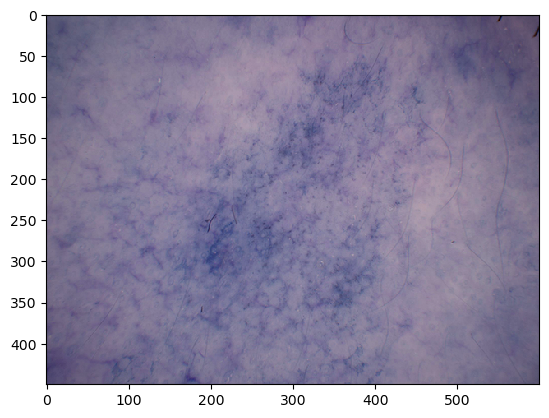

(256, 256, 3)
1/1 [==============================] - 0s 28ms/step
True Label:             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
131  ISIC_0034459  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Predicted Label: [[0.14127916 0.43118954 0.17006186 0.06514943 0.12694708 0.02074847
  0.04462443]]


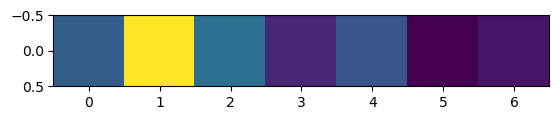

In [28]:
pred_folder = "validation/ISIC2018_Task3_Validation_Input/"
pred_image = "ISIC_0034459"
labels_path = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
classification.load_weights("final_class.h5")

pred_label_df = pd.read_csv(labels_path)
pred_label = pred_label_df.loc[pred_label_df['image']==pred_image]


test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))

plt.imshow(test_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)
#pred_image = tf.stack(pred_image)
pred = classification.predict(pred_image[None,])
#pred = np.argmax(classification.predict(pred_image[None,]), axis=-1)

#img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
print(f"True Label: {pred_label}")
print(f"Predicted Label: {pred}")

plt.imshow(pred, interpolation='nearest')
plt.show() 


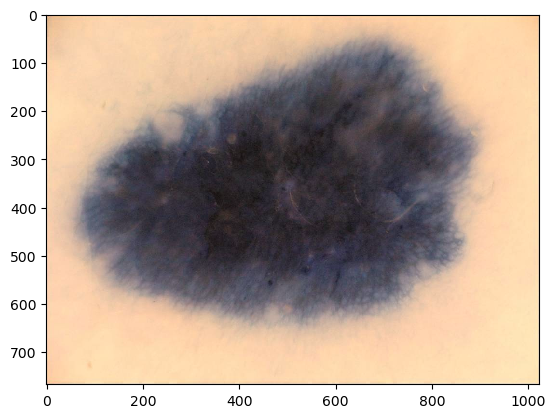

(256, 256, 3)


ValueError: in user code:

    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "unet" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 256, 3)


In [68]:
pred_folder = "seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0000000.jpg")))

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
print(pred_image.shape)
#pred_image = tf.stack(pred_image)

pred = model.predict(pred_image, batch_size=1)

#img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
plt.imshow(pred, interpolation='nearest')
plt.show() 